### Clustering and T-SNE Learning (without pipeline)

---


### A. Import Python Modules and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn import metrics #needed for Silhouette method
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]

#### Load the dataset

In [70]:
df = pd.read_csv("./tracks.csv")
df.tail()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
1495,23,352371,False,0.273,0.122,0,-22.173,0,0.0575,0.960,0.003330,0.0635,0.0731,117.718,4,opera
1496,22,204310,False,0.457,0.498,6,-8.387,1,0.0368,0.766,0.000002,0.2890,0.2020,116.255,4,opera
1497,23,225506,False,0.241,0.207,1,-16.353,1,0.0374,0.982,0.002260,0.1140,0.0735,86.885,1,opera
1498,23,148600,False,0.280,0.208,5,-20.158,1,0.0521,0.941,0.000200,0.4100,0.2410,90.477,4,opera
1499,23,257800,False,0.244,0.205,3,-15.596,1,0.0367,0.984,0.329000,0.0788,0.0750,71.370,4,opera


In [71]:
df.isna().sum()

,0
popularity,0
duration_ms,0
explicit,0
danceability,0
energy,0
key,0
loudness,0
mode,0
speechiness,0
acousticness,0


Genre is dropped, as it is categorical data.

Explicit is mapped to 0 and 1, to replace the bool, as well as to be more consistent with other features being in the range of 0-1

Popularity is changed to a boolean value of 0 and 1, with songs ranked over 50 being considered popular. This produced better results for clustering and a more definitive silhouette coefficient.

In [72]:
df.drop(columns=["track_genre"], inplace=True, errors='ignore')

bool_mapper = {
    False: 0,
    True: 1,
}
df['popularity'] = df['popularity'].apply(lambda x: 1 if x > 50 else 0)
df['explicit'] = df['explicit'].replace(bool_mapper)
df.tail()

<ipython-input-72-0462316be9ed>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['explicit'] = df['explicit'].replace(bool_mapper)


,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
1495,0,352371,0,0.273,0.122,0,-22.173,0,0.0575,0.960,0.003330,0.0635,0.0731,117.718,4
1496,0,204310,0,0.457,0.498,6,-8.387,1,0.0368,0.766,0.000002,0.2890,0.2020,116.255,4
1497,0,225506,0,0.241,0.207,1,-16.353,1,0.0374,0.982,0.002260,0.1140,0.0735,86.885,1
1498,0,148600,0,0.280,0.208,5,-20.158,1,0.0521,0.941,0.000200,0.4100,0.2410,90.477,4
1499,0,257800,0,0.244,0.205,3,-15.596,1,0.0367,0.984,0.329000,0.0788,0.0750,71.370,4


In [73]:
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (1500, 15)


In [74]:
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

---

### Scatterplot




In [48]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):


    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1],
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

---
### K-Means Clustering (Roy)

Number of clusters $k$.

For determining the ideal value of K, the elbow-method was used, mapping the sum of squares of the clusters to the graph. When the decline starts to flatten, like a bent elbow, that is the ideal value of k.

Through this, k=3 was the ideal value of k

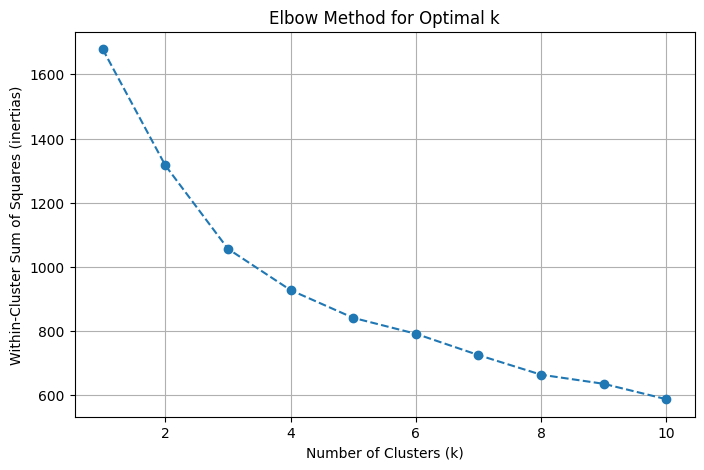

In [76]:
inertias = [] # the sum of squared distances
k_values = range(1, 11)

for k in k_values:
    kmeans = cluster.KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (inertias)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [85]:
k = 4

#### Run k-Means

In [86]:
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data)

### E. Apply a manifold-learning technique to project the data set to a 2D space

https://scikit-learn.org/stable/modules/manifold.html

Append the cluster centers to the dataset.

In [87]:
data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]

#### E2. Apply t-SNE to project both the data and the k-Means cluster centers to a 2D space

Project both the data and the k-Means cluster centers to 2D.

In [88]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


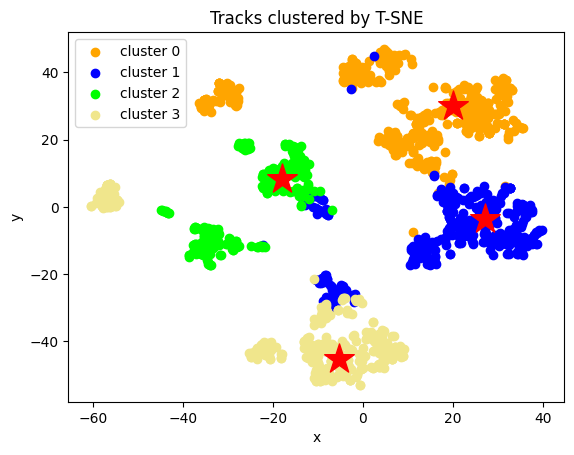

In [89]:
clustering_scatterplot(points=XYcoordinates[:-k,:],
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:],
                       title='Tracks clustered by T-SNE')

### F. Cluster Analysis

#### Add the cluster labels as an extra column in the original dataframe

In [91]:
df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)

In [92]:
df.tail()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,cluster
1495,0,352371,0,0.273,0.122,0,-22.173,0,0.0575,0.960,0.003330,0.0635,0.0731,117.718,4,1
1496,0,204310,0,0.457,0.498,6,-8.387,1,0.0368,0.766,0.000002,0.2890,0.2020,116.255,4,1
1497,0,225506,0,0.241,0.207,1,-16.353,1,0.0374,0.982,0.002260,0.1140,0.0735,86.885,1,1
1498,0,148600,0,0.280,0.208,5,-20.158,1,0.0521,0.941,0.000200,0.4100,0.2410,90.477,4,1
1499,0,257800,0,0.244,0.205,3,-15.596,1,0.0367,0.984,0.329000,0.0788,0.0750,71.370,4,1


#### Compute the mean value of each attribute for each cluster

In [93]:
df.groupby('cluster').mean()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
cluster,,,,,,,,,,,,,,,
0,0.000000,201258.824847,0.148676,0.632939,0.750532,4.680244,-5.696859,1.000000,0.094738,0.113558,0.199518,0.205758,0.445613,126.521436,3.967413
1,0.089109,227942.995050,0.000000,0.304934,0.252006,4.831683,-14.871869,0.868812,0.045222,0.877228,0.206267,0.201147,0.198265,102.729101,3.663366
2,1.000000,201642.031373,0.101961,0.620663,0.674706,4.992157,-5.984176,0.545098,0.067861,0.222890,0.119830,0.162611,0.453702,117.909627,3.929412
3,0.000000,206556.031429,0.165714,0.626766,0.711989,5.834286,-6.104851,0.000000,0.097500,0.156858,0.108718,0.195755,0.437807,119.129166,3.971429


- Cluster 0 are unpopular tracks all in major.
- Cluster 1 are quieter, acoustic, lower-tempo, lower-energy tracks.
- Cluster 2 tracks that rank from 50-100 in popularity.
- Cluster 3 are unpopular tracks all in minor.

# Clustering with DBScan (Adam)

# G - Sum of Squared distances
